## Chapter7. RNN을 사용한 문장 생성

### 1. 언어 모델을 사용한 문장 생성
- 언어 모델은 다양한 애플리케이션에서 활용 가능
- 대표적인 예로 기계 번역, 음성 인식, 문장 생성 등이 있다

1.1 RNN을 사용한 문장 생성의 순서
- 언어 모델은 지금까지 주어진 단어들에서 다음에 출현하는 단어의 확률분포를 출력
- 확률이 가장 높은 단어를 선택하는 방법 deterministic 과 확률적으로 선택하는 방법 probabilistic

1.2 문장 생성 구현
- Rnnlm 클래스 상속 RnnlmGen 클래스 생성

In [1]:
import sys
sys.path.append('D:/Python/14.밑바닥부터시작하는딥러닝/2/ch07')
import numpy as np
from common.functions import softmax
from ch06.rnnlm import Rnnlm
from ch06.better_rnnlm import BetterRnnlm

class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x)
            p = softmax(score.flatten())

            sampled = np.random.choice(len(o), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

In [2]:
# RnnlmGen 클래스 사용 문장 생성
import sys
sys.path.append('D:/Python/14.밑바닥부터시작하는딥러닝/2/ch07')
from rnnlm_gen import RnnlmGen
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params('./ch06/Rnnlm.pkl')

# 시작(start) 문자와 건너뜀(skip) 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

# 문자 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you 'll realize and its patients covered his normal international business facility of the august guarantee.
 while the army and industry law william george old the old house abramson to make jail planning for washington to owning the leaseway committee.
 mr. roman will cut goals.
 coke considered top of any scandal created by bush and veto.
 former jurors should help make democrats in aid.
 in addition to both abuse american advisers oppose that a addition to the east of this crime was this sign of the promise of news that will introduce coming more small


In [3]:
# RnnlmGen 클래스 사용 문장 생성
import sys
sys.path.append('D:/Python/14.밑바닥부터시작하는딥러닝/2/ch07')
from common.np import *
from rnnlm_gen import BetterRnnlmGen
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)


model = BetterRnnlmGen()
model.load_params('D:/Python/14.밑바닥부터시작하는딥러닝/2/ch07/BetterRnnlm.pkl')

# start 문자와 skip 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')

print(txt)


model.reset_state()

start_words = 'the meaning of life is'
start_ids = [word_to_id[w] for w in start_words.split(' ')]

for x in start_ids[:-1]:
    x = np.array(x).reshape(1, 1)
    model.predict(x)

word_ids = model.generate(start_ids[-1], skip_ids)
word_ids = start_ids[:-1] + word_ids
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print('-' * 50)
print(txt)

you 's going to feel where the disaster came to the marketplace said jeffrey mccall 's editor in new york.
 it 's hard to make more he said.
 earnings from the north sea business administration mark one of the most fundamental growth sparked by wall street 's desire to drum up the business in the u.s. economy.
 that increased he 's shares in the currency and then requests to spot cash.
 moody 's said the program was stronger than the the deal by italy and colorado airlines for the merger.
 most bonds fell no reaction
--------------------------------------------------
the meaning of life is a principal mess.
 rather than describe any other investment it has been ambitious citing both the all healthy regions that would allow pcs to trade abroad.
 international business machines corp. in the u.s. has still met while net income from the second ship of four billion it is rumored to remain early.
 but recent changes in the selling they are currently poised for seeing foam than the illness we

### 2. seq2seq
- 시계열 데이터를 다른 세계열 데이터로 변환하는 모델을 위한 기법으로 2개의 RNN을 이용하는 seq2seq sequence to sequence 방법 사용

2.1 seq2seq의 원리
- Encoder-Decoder 모델이라고도 한다. 2개의 모듈, Encoder는 입력데이터를 인코딩(부호화)하고, Decoder는 인코딩된 데이터를 디코딩(복호화) 한다
- Encoder는 RNN을 이용해 시계열 데이터를 h라는 은닉 상태 벡터로 변환
- Encoder가 출력하는 벡터 h는 LSTM 계층의 마지막 은닉 상태. 마지막 은닉상태 h에 입력 문장을 번역하는 데 필요한 정보가 인코딩. h는 고정 길이 벡터
- Decoder는 앞 절의 신경망가 같은 구조이지만 LSTM 계층이 벡터 h를 입력 받는다
- 순전파 때는 Encoder에서 인코딩된 정보가 LSTM 계층의 은닉 상태를 통해 Decoder에 전해지고 seq2seq의 역전파 때는 이 가교를 통해 기울기가 Decoder로부터 Encoder로 전해진다

2.2 시계열 데이터 변환용 장난감 문제
- 머신러닝을 평가하고자 만든 간단한 문제를 장난감 문제 toy problem라고 한다
- 단어단위 분할이 아닌 문자 단위 분할. ex) "57+5" 가 입력 되면 ['5','7','+','5'] 리스트로 처리

2.3 가변 길이 시계열 데이터
- 샘플마다 데이터의 시간 방향 크기가 다른 가변 길이 시계열 데이터를 다룬다
- 가변 길이 시계열 데이터를 미니배치로 학습하기 위한 가장 단순한 방법은 패딩 padding을 사용 하는 것
- 패딩을 적용해 데이터 크기를 통일시키면 가변 길이 시계열 데이터도 처리할수 있지만 원래는 존재하지 않던 패딩용 문자까지 seq2seq가 처리하게 된다
- 따라서 패딩을 적용해야 하지만 정확성이 중요하다면 seq2seq에 패딩 전용 처리를 추가해야 한다
- Decoder에 입력된 데이터가 패딩이라면 손실의 결과를 미반영 (softmax with loss 계층에 마스크 기능 추가)
- Encoder에 입력된 데이터가 패딩이라면 LSTM 계층이 이전 시각의 입력을 그대로 출력. LSTM계층은 마치 처음부터 패딩이 존재하지 않았던 것처럼 인코딩

2.4 덧셈 데이터셋

In [4]:
import sys
sys.path.append('D:/Python/14.밑바닥부터시작하는딥러닝/2/ch07')
from dataset import sequence

(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt', seed=1984)
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)
### (45000, 7) (45000,5)
### (5000, 7) (5000, 5)

print(x_train[0])
print(t_train[0])
### [ 3 0 2 0 0 11 5 ]
### [ 6 0 11 7 5 ]

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))
### 71+118
### _189

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]
71+118 
_189 


### 3. seq2seq 구현

3.1 Encoder 클래스
- Encoder 클래스는 문자열을 받아 벡터 h로 변환
- Embedding 계층과 LSTM 계층으로 구성

In [5]:
class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random_randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

3.2 Decoder 클래스
- Decoder는 RNN으로 구현. Encoder와 마찬가지로 LSTM 계층을 사용
- 덧셈에 대한 문제이므로 확률적인 비결정성을 배제, 결정적인 답을 생성
- argmax 노드를 통해 최대값을 가진 원소의 인덱스를 선택
- Softmax with Loss 계층은 이후 구현하는 Seq2seq 클래스에서 처리하고, Decoder 클래스는 Time Softmax with Loss 계층의 앞까지 담당

In [6]:
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * h).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)
        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh

    # 문장 생성 담당
    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))
        return sampled

3.3 Seq2seq 클래스
- Encoder 클래스와 Decoder 클래스 연결, Time Softmax with Loss 계층을 이용해 손실을 계산

In [7]:
from common.time_layers import *
from common.base_model import BaseModel

class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]
        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

3.4 seq2seq 평가
- seq2seq의 학습은 기본적인 신경망의 학습과 같은 흐름
- 학습 데이터에서 미니매치를 선택하고, 미니배치로부터 기울기를 계산하고, 기울기를 사용하여 매개변수 갱신

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from seq2seq import Seq2seq
from peeky_seq2seq import PeekySeq2seq

# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 모델 / 옵티마이저 / 트레이너 생성
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)
                
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose)
    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc*100))

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.53
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 1[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 2[s] | 손실 1.92
| 에폭 1 |  반복 101 / 351 | 시간 2[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 3[s] | 손실 1.85
| 에폭 1 |  반복 141 / 351 | 시간 4[s] | 손실 1.83
| 에폭 1 |  반복 161 / 351 | 시간 4[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 5[s] | 손실 1.77
| 에폭 1 |  반복 201 / 351 | 시간 5[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 6[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 6[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 7[s] | 손실 1.76
| 에폭 1 |  반복 281 / 351 | 시간 8[s] | 손실 1.75
| 에폭 1 |  반복 301 / 351 | 시간 8[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 9[s] | 손실 1.75
| 에폭 1 |  반복 341 / 351 | 시간 9[s] | 손실 1.74
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 666 
X 1000
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1000
---
Q 600+257
T 857 
X 1000
---
Q 761+292
T 1053
X 1000
---
Q 830+597
T 1427
X 1000
---
Q 26+838

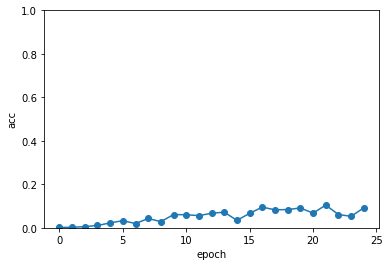

In [15]:
# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.ylim(0, 1.0)
plt.show()

### 4. seq2seq 개선
- seq2seq를 세분화하여 학습 속도를 개선

4.1 입력 데이터 반전(Reverse)

- 첫 번째 개선안은 아주 쉬운 트릭으로, 입력 데이터의 순서를 반전시키는 것이다
- 이 트릭을 사용하면 많은 경우 학습 진행이 빨라져서, 결과적으로 최종 정확도도 좋아진다고 한다
- x_train[:, ::-1] 표기법 사용. 위의 코드에서 반전여부 설정 True 변경
- 입력 문장의 첫 부분에서는 반전 덕분에 대응하는 변환 후 단어와 가까우므로, 기울기가 더 잘 전해져 학습 효율이 좋아진다
- 다만, 입력 데이터를 반전해도 단어의 평균적인 거리는 그대로이다

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 151 / 351 | 시간 5[s] | 손실 2.00
| 에폭 1 |  반복 301 / 351 | 시간 11[s] | 손실 1.76
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 666 
X 1001
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1001
---
Q 600+257
T 857 
X 1000
---
Q 761+292
T 1053
X 1000
---
Q 830+597
T 1427
X 1000
---
Q 26+838 
T 864 
X 1001
---
Q 143+93 
T 236 
X 703 
---
검증 정확도 0.120%
| 에폭 2 |  반복 1 / 351 | 시간 0[s] | 손실 1.73
| 에폭 2 |  반복 151 / 351 | 시간 6[s] | 손실 1.70
| 에폭 2 |  반복 301 / 351 | 시간 12[s] | 손실 1.63
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 666 
X 690 
---
Q 8+155  
T 163 
X 1000
---
Q 367+55 
T 422 
X 470 
---
Q 600+257
T 857 
X 700 
---
Q 761+292
T 1053
X 1000
---
Q 830+597
T 1427
X 1444
---
Q 26+838 
T 864 
X 700 
---
Q 143+93 
T 236 
X 370 
---
검증 정확도 0.400%
| 에폭 3 |  반복 1 / 351 | 시간 0[s] | 손실 1.52
| 에폭 3 |  반복 151 / 351 | 시간 6[s] | 손실 1.47
| 에폭 3 |  반복 301 / 351 | 시간 12[s] | 손실 1.34
Q 77+85  
T 162 
X 158 
---


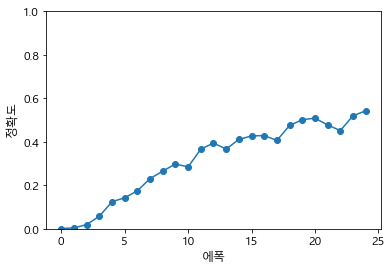

In [10]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
plt.rc('font', family=font_name, size=12)
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from seq2seq import Seq2seq
# from peeky_seq2seq import PeekySeq2seq


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
model = Seq2seq(vocab_size, wordvec_size, hideen_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

reverse_acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad, eval_interval=150)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    reverse_acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x_reverse = np.arange(len(reverse_acc_list))
plt.plot(x_reverse, reverse_acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

4.2 엿보기(Peeky)
- Encoder의 출력 h는 첫 번째 LSTM 계층만이 받는다
- 중요한 정보가 담긴 Encoder의 출력 h를 모든 시각의 LSTM 계층과 Affine 계층에 전달
- LSTM과 Affine 계층에 입력되는 두 벡터를 연결시키는 concat 노드를 이용해 하나의 벡터가 입력된다

In [8]:
# coding: utf-8
from common.time_layers import *
from seq2seq import Seq2seq, Encoder


class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None

    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H)  # 매 timestep 입력
        out = np.concatenate((hs, out), axis=2)  # concat 후 LSTM으로 입력

        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis=2)  # concat 후 Affine으로 입력

        score = self.affine.forward(out)
        self.cache = H
        return score

    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1)
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)

        return sampled


class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.57
| 에폭 1 |  반복 151 / 351 | 시간 6[s] | 손실 1.99
| 에폭 1 |  반복 301 / 351 | 시간 13[s] | 손실 1.76
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1013
---
Q 582+84 
T 666 
X 102 
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1023
---
Q 600+257
T 857 
X 1023
---
Q 761+292
T 1053
X 1023
---
Q 830+597
T 1427
X 1111
---
Q 26+838 
T 864 
X 102 
---
Q 143+93 
T 236 
X 102 
---
검증 정확도 0.280%
| 에폭 2 |  반복 1 / 351 | 시간 0[s] | 손실 1.71
| 에폭 2 |  반복 151 / 351 | 시간 6[s] | 손실 1.70
| 에폭 2 |  반복 301 / 351 | 시간 13[s] | 손실 1.64
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1200
---
Q 582+84 
T 666 
X 690 
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 690 
---
Q 600+257
T 857 
X 999 
---
Q 761+292
T 1053
X 1029
---
Q 830+597
T 1427
X 1240
---
Q 26+838 
T 864 
X 792 
---
Q 143+93 
T 236 
X 290 
---
검증 정확도 0.400%
| 에폭 3 |  반복 1 / 351 | 시간 0[s] | 손실 1.58
| 에폭 3 |  반복 151 / 351 | 시간 7[s] | 손실 1.54
| 에폭 3 |  반복 301 / 351 | 시간 14[s] | 손실 1.43
Q 77+85  
T 162 
X 154 
---


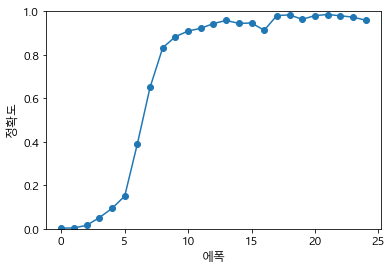

In [11]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
plt.rc('font', family=font_name, size=12)
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from seq2seq import Seq2seq
from peeky_seq2seq import PeekySeq2seq


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
# model = Seq2seq(vocab_size, wordvec_size, hideen_size)
model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

peeky_acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad, eval_interval=150)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    peeky_acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x_peeky = np.arange(len(peeky_acc_list))
plt.plot(x_reverse, peeky_acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

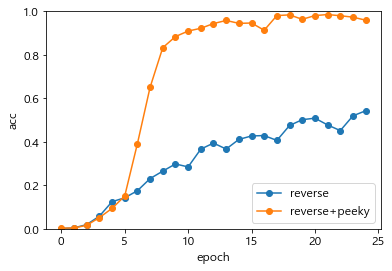

In [15]:
# 그래프 그리기
x = np.arange(len(reverse_acc_list))
plt.plot(x_reverse, reverse_acc_list, marker='o', label='reverse')

x = np.arange(len(peeky_acc_list))
plt.plot(x_reverse, peeky_acc_list, marker='o', label='reverse+peeky')

plt.xlabel('epoch')
plt.ylabel('acc')
plt.ylim(0, 1.0)
plt.legend()
plt.show()

### 5. seq2seq를 이용하는 애플리케이션
- seq2seq는 한 시계열 데이터를 다른 시계열 데이터로 변환. 시계열 변환 프레임 워크는 다양한 문제에 적용
- 기계번역 : 한 언어의 문장을 다른 언어의 문장으로 변환
- 자동 요약 : 긴 문장을 짧게 요약된 문장으로 변환
- 메일 자동 응답 : 받은 메일의 문장을 답변 글로 변환

5.1 챗봇
- 사람과 컴퓨터가 텍스트로 대화를 나누는 프로그램
- 상대방의 말을 자신의 말로 변환하는 문제
- 대화 기반으로 정답이나 힌트를 얻는 방식은 실용성이 높고 아양하게 응용 효과를 볼수 있다

5.2 알고리즘 학습
- 앞에서 수행한 덧셈과 같은 간단한 문제에서 더 고처원적인 문제도 처리
- 자연어처럼 소스 코드처리도 가능

5.3 이미지 캡셔닝
- 텍스트 외에도 이미지나 음성 등 다양한 데이터 처리
- 이미지 캡셔닝 Image Captioning : 이미지를 문장으로 변환
- Encoder에서 LSTM 대신 합성곱 신경망 Convolutional Neural Network CNN 사용
- CNN에는 VGG나 ResNet 등의 입증된 신경망을 사용하고, 가중치로는 다른 이미지 데이터셋(ImageNet 등)으로 학습을 끝낸 것을 이용한다
- 이렇게 하면 좋은 인코딩을 얻을 수 있고, 좋은 문장을 생성 할 수 있다

### 6. 정리
- RNN을 이용한 언어 모델은 새로운 문장을 생성할 수 있다
- 문장을 생성할 때는 하나의 단어(혹은 문자)를 주고 모델의 출력(확률분포)에서 샘플링하는 과정을 반복한다
- RNN을 2개 조합함으로써 시계열 데이터를 다른 시계열 데이터로 변환할 수 있다
- seq2seq는 Encoder가 출발어 입력문을 인코딩하고, 인코딩된 정보를 Decoder가 받아 디코딩하여 도착어 출력문을 얻는다
- 입력문을 반전시키는 기법(Reverse), 또는 인코딩된 정보를 Decoder의 여러 계층에 전달하는 기법(Peeky)은 seq2seq의 정확도 향상에 효과적이다
- 기계 번역, 챗봇, 이미지 캡셔닝 등 seq2seq는 다양한 애플리케이션에 이용할 수 있다